In [13]:
# general purpose imports
import os
import sys
import numpy as np
import pandas as pd
import scipy

# SMRT imports
from smrt import make_snowpack, sensor_list, make_model
from smrt.utils import dB

# DMRT-QMS bindings import
# you can disable DMRT-QMS (long computation) by setting to False
have_dmrtqms = True
# note that to import this binding, you need to install oct2py.
# If not available comment this line and don't execute the cell DMRT-QMS below
if have_dmrtqms:
    from smrt.utils import dmrt_qms_legacy

# Import of DMRT-ML if available
try:
    dmrtml_path = os.environ['DMRTML_DIR']
except KeyError:
    have_dmrtml = False
else:
    have_dmrtml = True
    sys.path.append(dmrtml_path)
    import dmrtml

# Graphics import
%matplotlib notebook
import matplotlib.pyplot as plt
color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']

In [14]:
## prepare inputs: snowpack with two layers

density = [300]
temperature = [265]
thickness = [200]
radius = [100e-6]
stickiness = [0.5]

snowpack = make_snowpack(thickness, "sticky_hard_spheres",
                        density=density, temperature=temperature, radius=radius, stickiness=stickiness)

# create the sensor
theta = np.arange(10, 65, 5)
radiometer = sensor_list.passive(37e9, theta)
radar = sensor_list.active(37e9, theta)

<IPython.core.display.Javascript object>


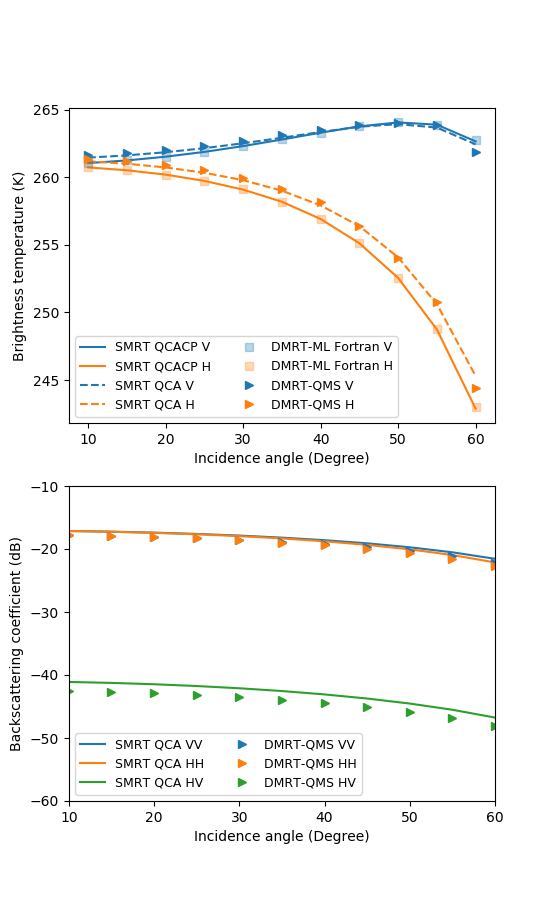

In [15]:
# create the SMRT Model with emmodel="dmrt_qcacp_shortrange" and rtsolver="dort"
m = make_model("dmrt_qcacp_shortrange", "dort")

# run the model
res_p = m.run(radiometer, snowpack)

# plots
f, axs =  plt.subplots(2, 1, figsize=(5.5,9))
axs[0].plot(theta, res_p.TbV(), label='SMRT QCACP V', color=color[0])
axs[0].plot(theta, res_p.TbH(), label='SMRT QCACP H', color=color[1])

axs[0].set_xlabel('Incidence angle (Degree)')
axs[0].set_ylabel ('Brightness temperature (K)')
axs[0].legend(loc='best')


In [16]:
m_qca = make_model("dmrt_qca_shortrange", "dort")

# run the model
res_qca = m_qca.run(radiometer, snowpack)
res_a = m_qca.run(radar, snowpack)

# plots
axs[0].plot(theta, res_qca.TbV(), '--', label='SMRT QCA V', color=color[0])
axs[0].plot(theta, res_qca.TbH(), '--', label='SMRT QCA H', color=color[1])

axs[1].plot(theta, dB(res_a.sigmaVV()), label='SMRT QCA VV', color=color[0])
axs[1].plot(theta, dB(res_a.sigmaHH()), label='SMRT QCA HH', color=color[1])
axs[1].plot(theta, dB(res_a.sigmaHV()), label='SMRT QCA HV', color=color[2])

axs[1].set_xlabel('Incidence angle (Degree)')
axs[1].set_ylabel ('Backscattering coefficient (dB)')
axs[1].legend(loc='best')

In [17]:
def rmsd(x):
    return float(np.sqrt(np.mean(np.square(x))))


# run dmrtml if available
if have_dmrtml:
    freq = radiometer.frequency                # frequency unity: Hz 

    medium='S' # SNOW
    n_max_stream = 64

    res = dmrtml.dmrtml(freq,n_max_stream,thickness,density,radius,temperature, tau=stickiness)
    axs[0].plot(theta,res.TbV(theta),'s',label='DMRT-ML Fortran V',alpha=0.3, color=color[0])
    axs[0].plot(theta,res.TbH(theta),'s',label='DMRT-ML Fortran H', alpha=0.3, color=color[1])
    
    print("RMSD(DMRTML-SMRT QCA)", rmsd(res.TbV(theta)-res_p.TbV()), rmsd(res.TbH(theta)-res_p.TbH()))
have_dmrtml

RMSD(DMRTML-SMRT QCA) 0.025368771103770373 0.033521161912417656


True

In [18]:
# run DMRT-QMS in passive mode
if have_dmrtqms:
    res_qms, ks_qms, ka_qms, eff_eps_snow = dmrt_qms_legacy.run(radiometer, snowpack, full_output=True)

    axs[0].plot(theta, res_qms.TbV(), '>', label='DMRT-QMS V', color=color[0])
    axs[0].plot(theta, res_qms.TbH(), '>', label='DMRT-QMS H', color=color[1])
    
    print("RMSD(DMRTQMS-SMRT QCA)", rmsd(res_qms.TbV()-res_qca.TbV()), rmsd(res_qms.TbH()-res_qca.TbH()))

 0.32715
 1.4791
RMSD(DMRTQMS-SMRT QCA) nan nan


ks= [ 0.00891995] 0.010851755389 ka= [ 0.27114819] 0.269180028514


<IPython.core.display.Javascript object>


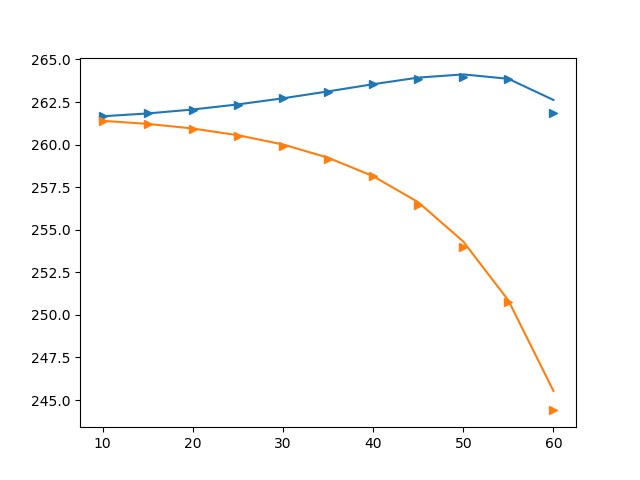

RMSD(DMRTQMS-SMRT PRE) nan nan


In [19]:
if have_dmrtqms:
    # get ks and ka from DMRT QMS
    
    em = m_qca.emmodel(radiometer, snowpack.layers[0])
    ks_qca = em.ks
    ka_qca = em.ka
    
    print("ks=", ks_qms, ks_qca, "ka=", ka_qms, ka_qca)
    
    m_tmp = make_model("prescribed_kskaeps", "dort")
    snowpack.layers[0].ks = ks_qms
    snowpack.layers[0].ka = ka_qms
    snowpack.layers[0].effective_permittivity = eff_eps_snow
    
    res = m_tmp.run(radiometer, snowpack)
    
    plt.figure()
    plt.plot(theta, res_qms.TbV(), '>', label='DMRT-QMS V', color=color[0])
    plt.plot(theta, res_qms.TbH(), '>', label='DMRT-QMS H', color=color[1])
    
    plt.plot(theta, res.TbV(), label='SMRT Prescribed V', color=color[0])
    plt.plot(theta, res.TbH(), label='SMRT Prescribed H', color=color[1])
    
    print("RMSD(DMRTQMS-SMRT PRE)", rmsd(res_qms.TbV()-res.TbV()), rmsd(res_qms.TbH()-res.TbH()))

In [20]:
# DMRT QMS does not work with Octave, the open source sibling of matlab (at least for some version of octave)
# Henning Loewe ran DMRTQMS under matlab. The results are gather here:

angle = [0.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0,55.0,60.0,65.0,70.0,75.0,80.0]
vv = [-17.7152,-17.7359,-17.7991,-17.9061,-18.0595,-18.2636,-18.5244,-18.8504,-19.2538,-19.7524,-20.3721,-21.1533,-22.1608,-23.4986,-25.3504,-28.0938,-32.7076]
hh = [-17.715,-17.7381,-17.8078,-17.926,-18.096,-18.3228,-18.6134,-18.9782,-19.4318,-19.9951,-20.6982,-21.5886,-22.7417,-24.27,-26.3698,-29.447,-34.5717]
hv = [-42.3597,-42.3891,-42.4776,-42.6269,-42.84,-43.1212,-43.4768,-43.9158,-44.451,-45.1007,-45.8911,-46.864,-48.0868,-49.6608,-51.7674,-54.7912,-59.7674]
vh = [-42.3598,-42.3891,-42.4776,-42.6269,-42.84,-43.1212,-43.4768,-43.9159,-44.451,-45.1006,-45.8913,-46.8642,-48.085,-49.6601,-51.7784,-54.822,-59.7593]

s = slice(2, -4)
axs[1].plot(angle[s], vv[s], '>', label='DMRT-QMS VV', color=color[0])
axs[1].plot(angle[s], hh[s], '>', label='DMRT-QMS HH', color=color[1])
axs[1].plot(angle[s], hv[s], '>', label='DMRT-QMS HV', color=color[2])
axs[1].set_xlim((10,60))
axs[1].set_ylim((-60,-10))


print("RMSD(DMRTQMS-SMRT PRE)", rmsd(vv[s]-dB(res_a.sigmaVV())), rmsd(hh[s]-dB(res_a.sigmaHH())), rmsd(hv[s]-dB(res_a.sigmaHV())))

RMSD(DMRTQMS-SMRT PRE) 0.6476397691986127 0.6500142690019798 1.3636605432157485


In [21]:

for ax in axs:
    ncol = 2  ##if ax==axs[1] else 2
    ax.legend(loc='best', prop={'size': 9}, ncol=ncol)
#f.savefig("fig_smrt_dmrt.pdf")